In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

# Variational Autoencoders

An autoencoder consists of two models: An encoder and a decoder. The Encoder takes any input and encodes it in  subsequently smaller dimensions as the layers decrease in size. At the end of the encoder is the _bottleneck_, where the encoding has the smallest dimensionality. This representation of the input data gets passed to the decoder which consists of layers ever-increasing in size until the exact dimensionality of the original input to the decoder is reached.

So far this is equivalent to a normal autoencoder architecture. The drawback of these is, that they learn to compress and restore the data as accurate as possible while having no restrictions on the latent representation. This leads to an encoder that produces clusters for similar looking input in the latent space. However these clusters are distinct and a sample vector from between two clusters has barely any meaningful decoding. This allows the usage for compression or denoising applications but generating new data from random input is impossible, for most of the time the output wouldn't make a lot of sense for the decoder. This is obvious as it has never seen input from the area of the latent space.

![image.png](images/ae_latent_space.png)
<small><i>Original figure from https://hackernoon.com/latent-space-visualization-deep-learning-bits-2-bd09a46920df</i></small>

VAEs avoid this drawback of regular autoencoders by not producing the latent verctor directly, but producting one vector of means and another vector of standard deviations. From the two vectors, the actual latent vector is sampled by generating a vector from a normal gaussian distribution, adding the mean and multiplying with the standard deviation.

![image.png](images/vae-aritechture.jpg)
<small><i>Figure taken from http://kvfrans.com/variational-autoencoders-explained/</i></small>

This leads to a latent vector that points to an area of maximum likelihood where the high dimensional input should be in the latent space.

Another constraint that is introduced in the loss function is, that the latent vector should be a sample from a normal distribution to center the estimated means around 0 and the estimated standard deviations around 1. It has the effect that the latent space is now densely sampled from and each value in the latent space has a meaningful representation in the original space of the input.

![image.png](images/latent_space.png)
<small><i>Figure taken from https://news.sophos.com/en-us/2018/06/15/using-variational-autoencoders-to-learn-variations-in-data/</i></small>

# Variational Autoencoder on MNIST

## Load MNIST-Data

Image shape: (28, 28)


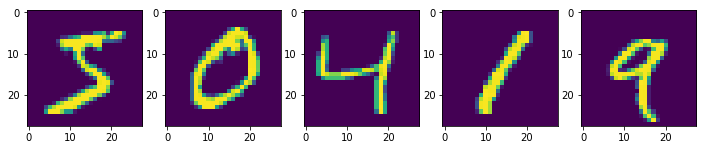

In [2]:
# load and normalize MNIST
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train, X_test = X_train / 255.0, X_test / 255.0

# show some samples
plt.figure(figsize=(12, 5))
print('Image shape:', np.shape(X_train[0]))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(X_train[i])

## Hyperparameters

In [3]:
Z_SIZE = 48
BATCH_SIZE = 128
EPOCHS = 50
E = 1e-10

## VAE-Network

In [4]:
def conv(inputs, filters, kernel_size, strides, activation=tf.nn.relu):
    return tf.layers.conv2d(inputs, filters, kernel_size, strides=(strides, strides),
                        padding='SAME', activation=activation)

def deconv(inputs, filters, kernel_size, strides, activation=tf.nn.relu):
    return tf.layers.conv2d_transpose(inputs, filters, kernel_size, strides=(strides, strides),
                        padding='SAME', activation=activation)

def sample(mean, std):
    with tf.variable_scope('random_sampling'):
        shape = tf.shape(mean)
        random_sample = tf.random_normal(shape)
        return mean + tf.exp(std * .5) * random_sample
    #noise = np.random.normal(loc=mean, scale=std, size=len(mean)) # * std + mean

In [5]:
tf.reset_default_graph()

# define variational autoencoder
with tf.variable_scope('Image-Input'):
    img_input = tf.placeholder(tf.float32, [None, 28, 28, 1])

with tf.variable_scope('Encoder', reuse=tf.AUTO_REUSE):
    encoding = conv(img_input, 32, 3, 2)
    encoding = conv(encoding, 64, 3, 2)
    encoding = conv(encoding, 128, 3, 1)
    flatten = tf.layers.flatten(encoding)
    
    #z = tf.layers.dense(flatten, Z_SIZE, activation=tf.nn.relu)
    z_mean = tf.layers.dense(flatten, Z_SIZE)
    z_std = tf.layers.dense(flatten, Z_SIZE)

with tf.variable_scope('Sample-Encoding'):
    z = sample(z_mean, z_std) 
    z_input = tf.placeholder_with_default(z, [None, Z_SIZE])
    #tf.cond(training, true_fn=sample(z_mean, z_std), false_fn=z_mean)
    #z_input = tf.placeholder(tf.float32, [None, Z_SIZE, 1])

with tf.variable_scope('Decoder', reuse=tf.AUTO_REUSE):
    decoding = tf.layers.dense(z_input, 7*7*128, activation=tf.nn.relu)
    decoding = tf.reshape(decoding, [-1, 7, 7, 128]) 
    decoding = deconv(decoding, 128, 3, 1)
    decoding = deconv(decoding, 64, 3, 2)
    decoding = deconv(decoding, 32, 3, 2)
    decoding = deconv(decoding, 1, 3, 1, activation=tf.nn.sigmoid) 
    
with tf.variable_scope('Loss', reuse=tf.AUTO_REUSE):
    #reconstruction_loss = tf.losses.mean_pairwise_squared_error(img_input, decoding)
    reconstruction_loss = tf.norm(img_input - decoding, ord='euclidean')
    #kl_divergence = 0.5 * tf.reduce_sum(tf.square(z_std) + tf.square(z_mean) \
    #                                    - tf.log(E + tf.square(z_std)) - 1, axis=1)
    kl_divergence = -0.5 * tf.reduce_sum(1.0 + 2.0 * z_std - tf.square(z_mean) - tf.exp(2.0 * z_std), 1)
    loss = tf.reduce_mean(reconstruction_loss + 0.5 * kl_divergence)
with tf.variable_scope('Train', reuse=tf.AUTO_REUSE):
    train = tf.train.AdamOptimizer(0.0001).minimize(loss)

## Tensorboard

In [6]:
tf.summary.scalar('reconstruction_loss/convolutional', tf.reduce_mean(reconstruction_loss))
tf.summary.scalar('kl_divergence/convolutional', tf.reduce_mean(kl_divergence))
tf.summary.scalar('loss/convolutional', tf.reduce_mean(loss))
tf.summary.scalar('z-mean/convolutional', tf.reduce_mean(z_mean))
tf.summary.scalar('z-std/convolutional', tf.reduce_mean(z_std))
tf.summary.histogram('encoding/convolutional', z_input)
tf.summary.image('Source-Image/convolutional', img_input)
tf.summary.image('Reconstructed-Image/convolutional', decoding)
summary = tf.summary.merge_all()

## Training Loop

Finished training epoch 10 with mean loss 56.905155
Finished training epoch 20 with mean loss 54.785316
Finished training epoch 30 with mean loss 53.750698
Finished training epoch 40 with mean loss 53.088768
Finished training epoch 50 with mean loss 52.59168


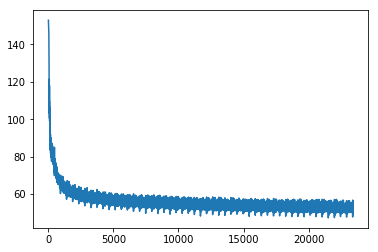

In [7]:
iterations_per_epoch = len(X_train) // BATCH_SIZE
losses = []

sess = tf.Session()

summary_writer = tf.summary.FileWriter('tensorboard', sess.graph)
sess.run(tf.global_variables_initializer())

for e in range(EPOCHS):
    for i in range(iterations_per_epoch):
        batch = X_train[i*BATCH_SIZE : (i+1) * BATCH_SIZE]
        batch = np.expand_dims(batch, 3)
        l, _ = sess.run([loss, train], feed_dict={ img_input : batch })
        losses.append(l)
        if i % 10 == 0:
            s = sess.run(summary, feed_dict={ img_input : batch })
            summary_writer.add_summary(s, e*iterations_per_epoch+i)
    if (e+1) % 10 == 0:
        print('Finished training epoch', e+1, 'with mean loss', np.mean(losses[-iterations_per_epoch:]))


plt.plot(losses)

## Test on unseen data

/media/luca/a87b7b03-b48e-49f3-903a-66c8d0de2388/python_projects/virt_envs/tf_venv/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  after removing the cwd from sys.path.


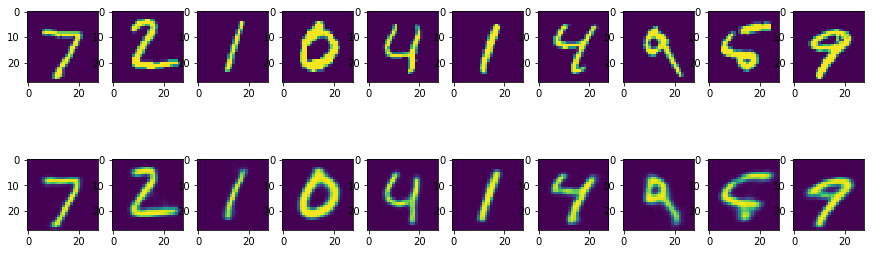

In [8]:
plt.figure(figsize=(15, 5))
for i in range(10):
    img = X_test[i]
    img_in = [np.expand_dims(img, 3)]
    reconstruction = sess.run(decoding, feed_dict={ img_input : img_in })
    plt.subplot(2, 10, (i+1))
    plt.imshow(img)
    plt.subplot(2, 10, (i+1+10))
    plt.imshow(np.reshape(reconstruction, [28, 28]))

## VAE with 2 dimensional latent space

In [9]:
D2_Z_SIZE = 2

In [10]:
tf.reset_default_graph()

# define variational autoencoder
with tf.variable_scope('2D_Image-Input'):
    img_input = tf.placeholder(tf.float32, [None, 28, 28, 1])

with tf.variable_scope('2D_Encoder', reuse=tf.AUTO_REUSE):
    encoding = conv(img_input, 32, 3, 2)
    encoding = conv(encoding, 64, 3, 2)
    encoding = conv(encoding, 128, 3, 1)
    flatten = tf.layers.flatten(encoding)
    
    #z = tf.layers.dense(flatten, Z_SIZE, activation=tf.nn.relu)
    z_mean = tf.layers.dense(flatten, D2_Z_SIZE)
    z_std = tf.layers.dense(flatten, D2_Z_SIZE)

with tf.variable_scope('2D_Sample-Encoding'):
    z = sample(z_mean, z_std) 
    z_input = tf.placeholder_with_default(z, [None, D2_Z_SIZE])
    #tf.cond(training, true_fn=sample(z_mean, z_std), false_fn=z_mean)
    #z_input = tf.placeholder(tf.float32, [None, Z_SIZE, 1])

with tf.variable_scope('2D_Decoder', reuse=tf.AUTO_REUSE):
    decoding = tf.layers.dense(z_input, 7*7*128, activation=tf.nn.relu)
    decoding = tf.reshape(decoding, [-1, 7, 7, 128]) 
    decoding = deconv(decoding, 128, 3, 1)
    decoding = deconv(decoding, 64, 3, 2)
    decoding = deconv(decoding, 32, 3, 2)
    decoding = deconv(decoding, 1, 3, 1, activation=tf.nn.sigmoid) 
    
with tf.variable_scope('2D_Loss', reuse=tf.AUTO_REUSE):
    #reconstruction_loss = tf.losses.mean_pairwise_squared_error(img_input, decoding)
    reconstruction_loss = tf.norm(img_input - decoding, ord='euclidean')
    #kl_divergence = 0.5 * tf.reduce_sum(tf.square(z_std) + tf.square(z_mean) \
    #                                    - tf.log(E + tf.square(z_std)) - 1, axis=1)
    kl_divergence = -0.5 * tf.reduce_sum(1.0 + 2.0 * z_std - tf.square(z_mean) - tf.exp(2.0 * z_std), 1)
    loss = tf.reduce_mean(reconstruction_loss + 0.5 * kl_divergence)

with tf.variable_scope('2D_Train', reuse=tf.AUTO_REUSE):
    train = tf.train.AdamOptimizer(0.0001).minimize(loss)

Finished training epoch 10 with mean loss 71.651375
Finished training epoch 20 with mean loss 70.06403
Finished training epoch 30 with mean loss 69.25312
Finished training epoch 40 with mean loss 68.69212
Finished training epoch 50 with mean loss 68.287224


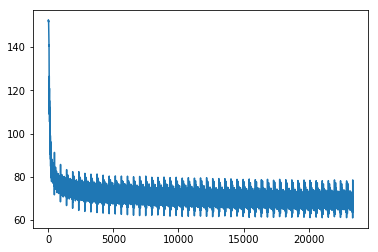

In [11]:
iterations_per_epoch = len(X_train) // BATCH_SIZE
losses = []

sess = tf.Session()

sess.run(tf.global_variables_initializer())

for e in range(EPOCHS):
    for i in range(iterations_per_epoch):
        batch = X_train[i*BATCH_SIZE : (i+1) * BATCH_SIZE]
        batch = np.expand_dims(batch, 3)
        l, _ = sess.run([loss, train], feed_dict={ img_input : batch })
        losses.append(l)
    
    if (e+1) % 10 == 0:
        print('Finished training epoch', e+1, 'with mean loss', np.mean(losses[-iterations_per_epoch:]))


plt.plot(losses)

## Visualization of the test set in the latent space

In [12]:
encodings = []
classes = []
for i in range(len(X_test)):
    img = X_test[i]
    img_in = [np.expand_dims(img, 3)]
    encoding = sess.run(z, feed_dict={ img_input : img_in })
    encodings.append(encoding[0])
    classes.append(y_test[i])
encodings = np.array(encodings)

/media/luca/a87b7b03-b48e-49f3-903a-66c8d0de2388/python_projects/virt_envs/tf_venv/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """


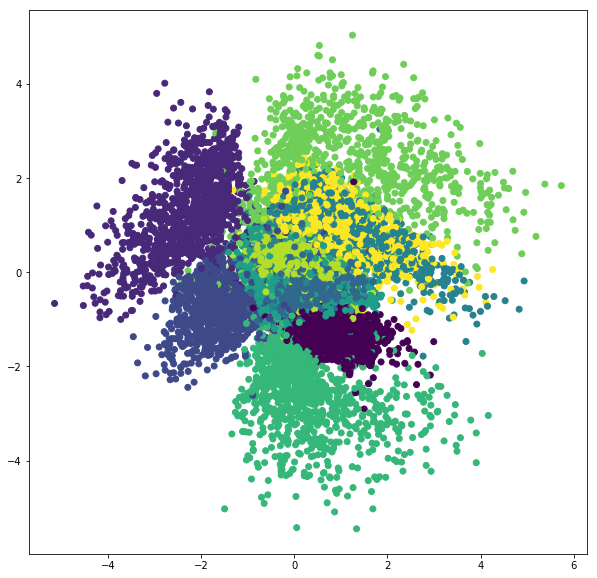

In [13]:
plt.figure(figsize=(10, 10))
plt.scatter(encodings[:, 0], encodings[:, 1], c=classes)

## Matrix of different decoded latent vectors

The vectors are generated according to position in the matrix.

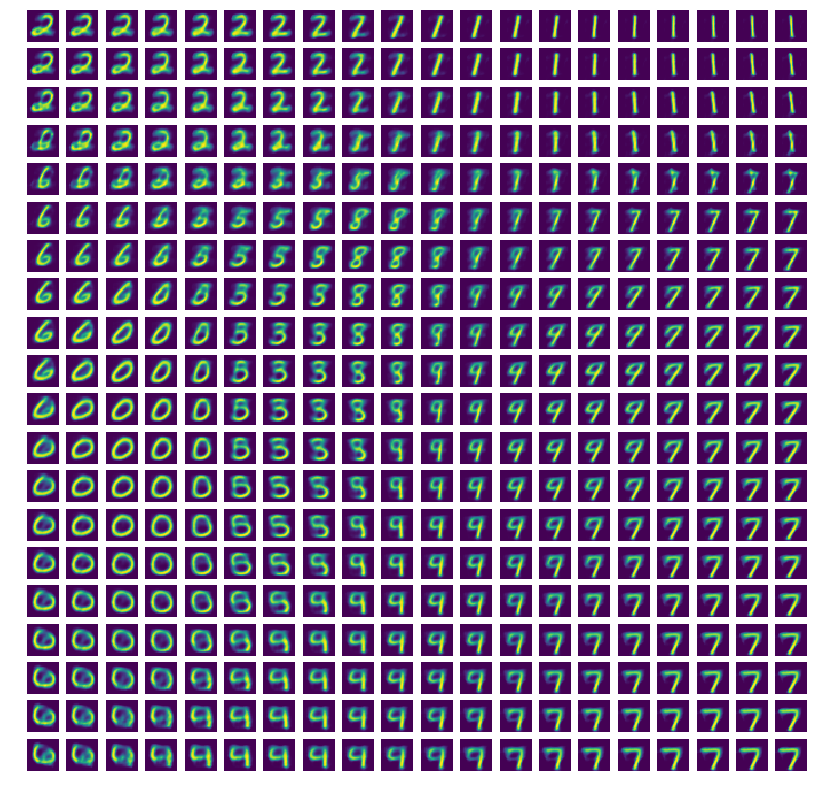

In [14]:
matrix_width, matrix_height = 20, 20
plt.figure(figsize=(14, 14))

for i in range(matrix_width * matrix_height):
    row, col = i // matrix_height, i % matrix_width
    sample_z = [row * 0.27 - 2, col * 0.27 - 2]
    construction = sess.run(decoding, feed_dict={ z_input : [sample_z] })
    plt.subplot(matrix_height, matrix_width, (i+1))
    plt.imshow(construction.reshape([28, 28]))
    plt.axis('off')